# Diffusion analysis
(c) Anezka (version 12.12.2024), using Marina's *trc_handling* functions (find in the group wikipedia/ask Anezka for them)

In this code, diffusion properties of the sample are calculated. Using a FOR cycle, analysis can be run over more samples at once.
  
- INPUT (for each sample = each measured well):
    - .h5 data (or use Locator included in this code, to generate your .h5 data)
    - .SPE files

  
- OUTPUT (for each sample = each measured well):
    1) MSD analysis over the whole sample (eg. 10 movies, analyzed together), from which **Mean diffusion coefficient** is defined
    2) MSD analysis over different spots (eg. 10 movies, analyzed separately) in one sample, resulting in plot comparing mean  **Diffusion coefficient** in different spots within one well
    - MSD analysis for individual trajectories in one sample, defining **Individiual diffusion coefficients** in each movie, these are compared in
        3) barplot of diffusion populations
        4) plot of individual diffusion coefficient with respect to trajectory length (number of frames) and their brightness value (assuming there is a correlation between brightness value and presence of aggregation)
        5) example image constructed from one movie, includes 1st frame of the movie and projection of all frames (to study mobility)
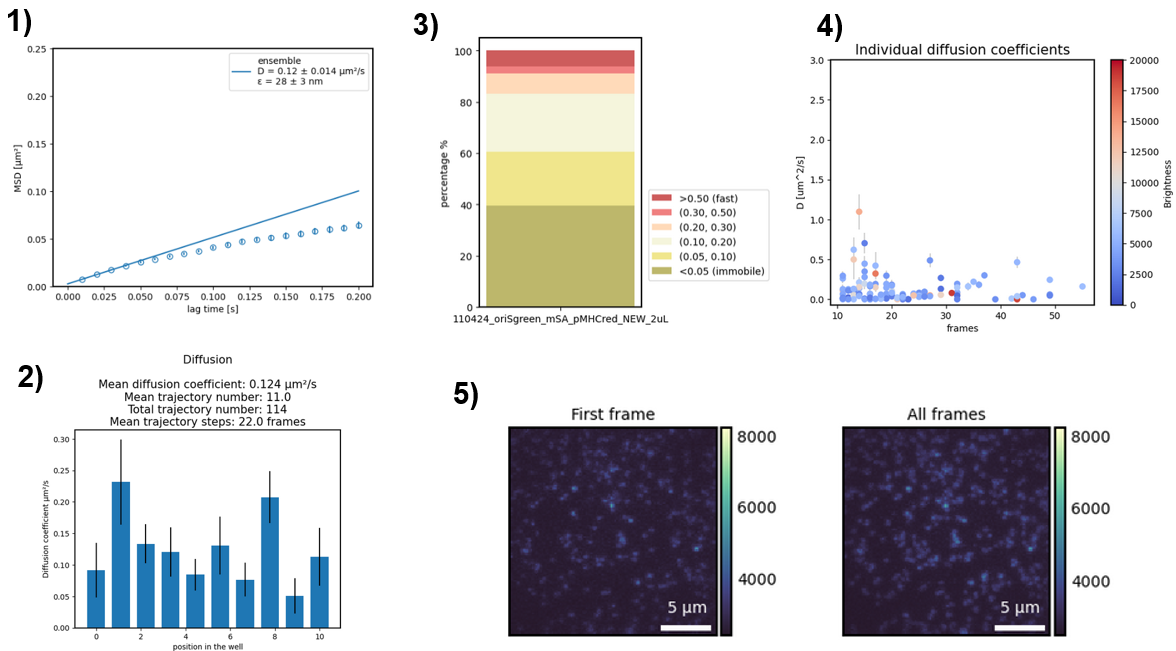


REFERENCE:
- https://schuetzgroup.github.io/sdt-python/
- https://github.com/schuetzgroup/sdt-python

# Packages

In [407]:
from pathlib import Path

import matplotlib.pyplot as plt
plt.close()

import pandas as pd
import pickle

from trc_handling import *



import numpy as np


import ipywidgets
from sdt import io, loc, motion, multicolor, nbui, brightness, roi
import trackpy

trackpy.quiet()
import traitlets

import subprocess
import sys

#for progressbar
from tqdm.notebook import tqdm, trange



import numpy as np
import matplotlib.pyplot as plt
from skimage import io as ios

from pathlib import Path
import seaborn_image as isns
 

# user input

- imaging parameters (IMPORTANT! this is based on your imaging procedure, namely illumination time and time delay)
- choose correct thresholds to define diffusion populations
   - if origami sample, set origami=True, else origami=False resulting in thresholds for protein diffusions

In [408]:
#imaging parameters
pixel_size = 0.16 #um
exp_time = 0.003 #s illumination
t_del = 0.007 #s
fps = 1/(t_del+exp_time) #frames per second
 


In [409]:
#tracking parameters
search_range=4
memory=2
min_track_length=1
first_frame=90
 

In [410]:
#if origami sample, origami=True, if proteins, origami=False
origami=False

#tresholds
if origami==True:
    immob_thresh =np.log(0.05)  #µm^2/s
    super_slow_tresh=np.log(0.10)
    slow_tresh=np.log(0.20)
    normal_tresh=np.log(0.30)
    fast_tresh=np.log(0.50)

    label_immobile='<0.05 (immobile)'
    label_superslow='(0.05, 0.10)'
    label_slow='(0.10, 0.20)'
    label_normal='(0.20, 0.30)'
    label_middle='(0.30, 0.50)'
    label_fast='>0.50 (fast)'
    
else:
    immob_thresh =np.log(0.05)  #µm^2/s
    super_slow_tresh=np.log(0.5)
    slow_tresh=np.log(1.0)
    normal_tresh=np.log(1.5)
    fast_tresh=np.log(2.5)   

    label_immobile='<0.05 (immobile)'
    label_superslow='(0.05, 0.5)'
    label_slow='(0.5, 1)'
    label_normal='(1,1.5)'
    label_middle='(1.5, 2.5)'
    label_fast='>2.50 (fast)'
 

In [411]:
#localization 
sys.executable
subprocess.run([sys.executable, "-m", "sdt.gui.locator"])
 

/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Exception ignored in: <function Pool.__del__ at 0x166ccd000>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sdt-env/lib/python3.10/multiprocessing/pool.py", line 271, in __del__
  File "/opt/anac

CompletedProcess(args=['/opt/anaconda3/envs/sdt-env/bin/python', '-m', 'sdt.gui.locator'], returncode=0)

In [412]:
#filenames of samples to be analyzed, each filename corresponds to one measured well
filenames=['20251002_26degrees_pmhc_20ng_slb1_130min', '20251002_26degrees_pmhc_20ng_slb1_210min', '20251002_26degrees_pmhc_20ng_slb1_260min', '20251002_26degrees_pmhc_20ng_slb2_130min', '20251002_26degrees_pmhc_20ng_slb2_210min', '20251002_26degrees_pmhc_20ng_slb2_260min']

In [413]:
#data path
data_dir= r'/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/origami_37vs26degrees_1002_1010/20251002_26degrees/pmhc/20ng'
data_loc, data_img= [],[]

#upload the .h5 file data, as a list
#upload the .tiff/.SPE data, as a list of images
for i in filenames:
    data = sorted(Path(data_dir).glob(f'**/{i}*.h5'))
    img_files = sorted(Path(data_dir).glob(f'**/{i}*.tiff')) 
    data_img.append(img_files)
    data_loc.append([io.load(f) for f in data])
    

In [414]:
len(data_img)

6

In [415]:
data_img

[[PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/origami_37vs26degrees_1002_1010/20251002_26degrees/pmhc/20ng/slb1/20251002_26degrees_pmhc_20ng_slb1_130min_roi_0.tiff'),
  PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/origami_37vs26degrees_1002_1010/20251002_26degrees/pmhc/20ng/slb1/20251002_26degrees_pmhc_20ng_slb1_130min_roi_1.tiff'),
  PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/origami_37vs26degrees_1002_1010/20251002_26degrees/pmhc/20ng/slb1/20251002_26degrees_pmhc_20ng_slb1_130min_roi_2.tiff'),
  PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/origami_37vs26degrees_1002_1010/20251002_26degrees/pmhc/20ng/slb1/20251002_26degrees_pmhc_20ng_slb1_130min_roi_3.tiff'),
  PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/origami_37vs26degrees_1002_1010/20251002_26degrees/pmhc/20ng/slb1/20251002_26degrees_pmhc_20ng_slb1_130min_roi_4.tiff'),
  PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg

# Analysis

## Z-projection/all frames stack (quick analysis)


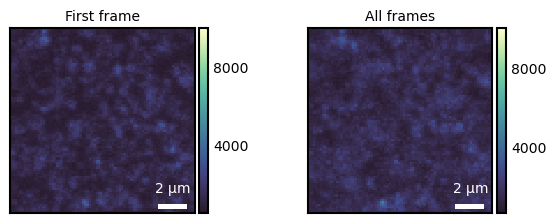

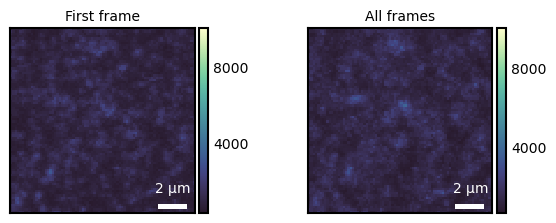

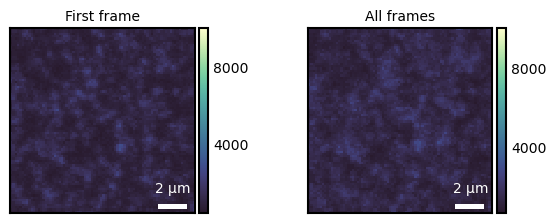

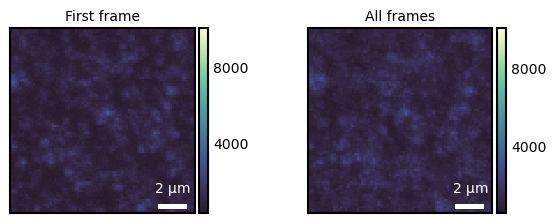

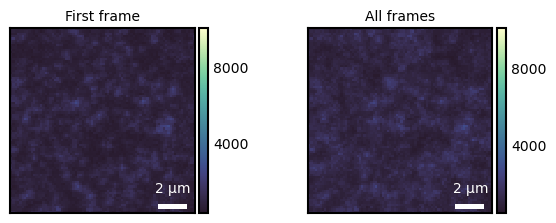

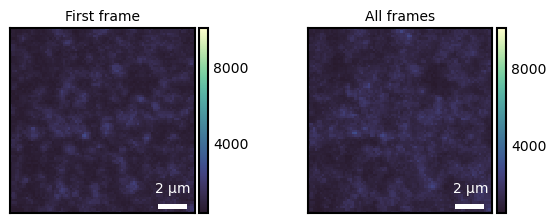

In [416]:
for z in range(0,len(data_img)):


    IM_3rd, IM_MAX=[],[]
    for w in data_img[z]:
        IM = ios.imread(w)
        IM_3rd.append(IM[0])
        #IM_MAX.append(np.max(IM[50:-1], axis=0))
        IM_MAX.append(np.max(IM, axis=0))

    fig, ax = plt.subplots(1, 2)

    isns.imgplot(IM_3rd[-1],vmin=None, vmax= 10000, ax=ax[0], dx=0.160, units='um')#, vmin=-1.2, vmax=1.2,)
    isns.imgplot(IM_MAX[-1],vmin=None, vmax= 10000, ax=ax[1], dx=0.160, units='um')
#ax[1].imshow(IM_MAX[1],vmin=None, vmax= 4200)
    plt.subplots_adjust(wspace=0.5)

    ax[0].set_title('First frame', size=10)
    ax[1].set_title("All frames", size=10)

    fig.savefig(f'{data_dir}/'+filenames[z]+"_Zstack_dif_scale.png")
     

## Tracking

In [417]:
trc,msd_ens,eps,msd_ind,fit_ind=[],[],[],[],[]
D,D_err,eps,eps_err=[],[],[],[]

for i in tqdm(range(0, len(filenames))):
    trc_all=[]
    for j in tqdm(range(0,len(data_loc[i]))):
        
        # tracking
       # if data_loc[i].empty == False:
       # trc_filter.append(trackpy.link(data_loc_roi[i], search_range=search_range, memory=memory))
        trc_all.append(trackpy.link(data_loc[i][j][data_loc[i][j]['frame']>first_frame], search_range=search_range, memory=memory))
   
    #filter your data by the chosen minimal track length (in steps)
    trc.append(min_track_filter(trc_all, min_track_length=min_track_length))
    
    #msd analysis for all trajectories
    msd_ens.append(motion.Msd(trc[i], fps, pixel_size=pixel_size, ensemble=True).fit("brownian", exposure_time=exp_time))
    eps.append(msd_ens[i].get_results()[0]['eps'])

    #msd analysis for individual trajectories  
    msd_ind.append(motion.Msd(trc[i], fps, pixel_size=pixel_size, ensemble=False))
    fit_ind.append(BrownianMotionFixedEps(msd_ind[i]._msd_data, eps[i], n_lag=2))
 

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## MSD analysis: mean diffusion coefficient

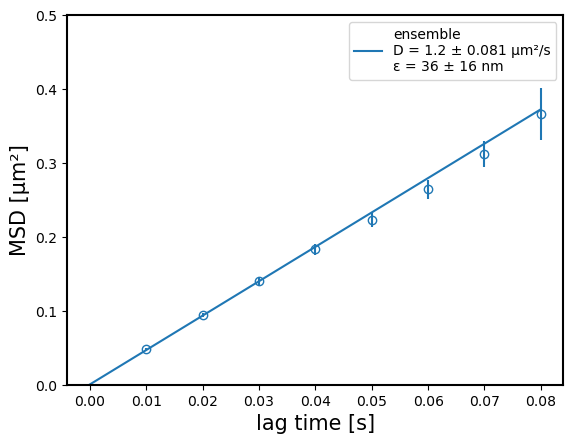

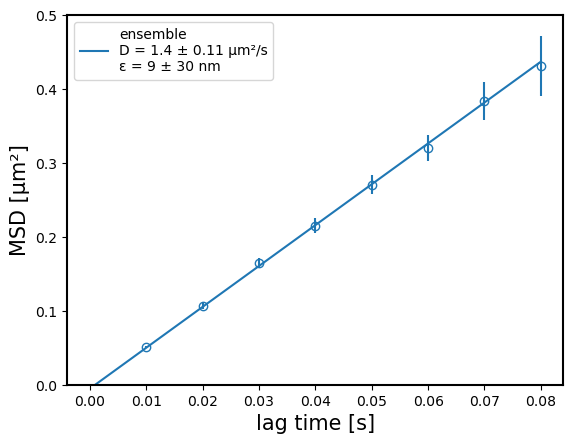

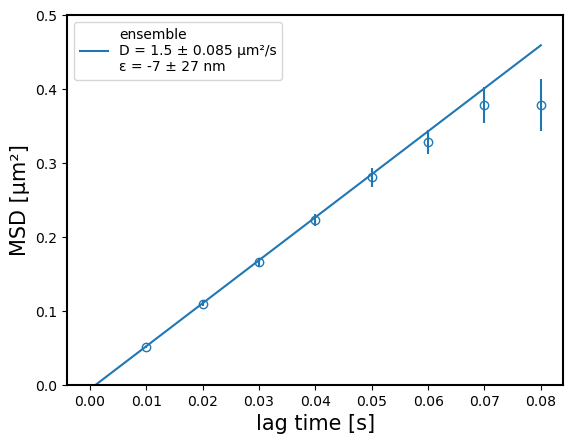

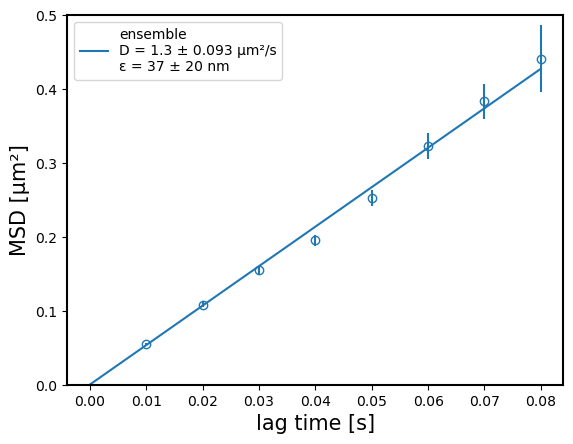

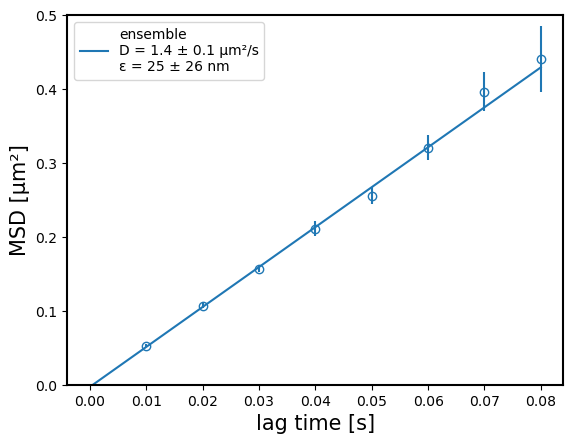

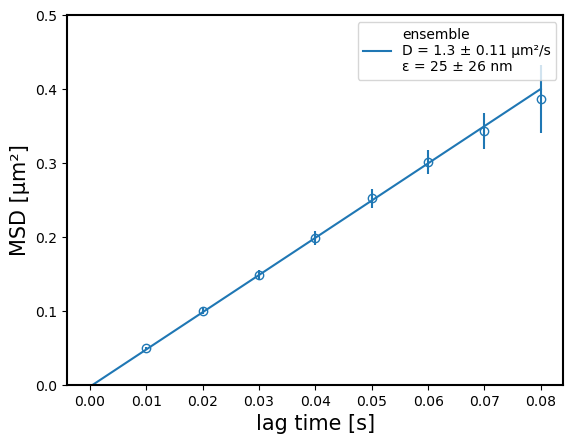

In [418]:
for i in range(0, len(filenames)):

    fig, ax = plt.subplots()

    msd_ens[i].plot(ax=ax)
    plt.ylim((0,0.5))

    
    
    fig.savefig(f'{data_dir}/'+filenames[i]+"_MSD.png")
 

## MSD analysis: different spots in one well

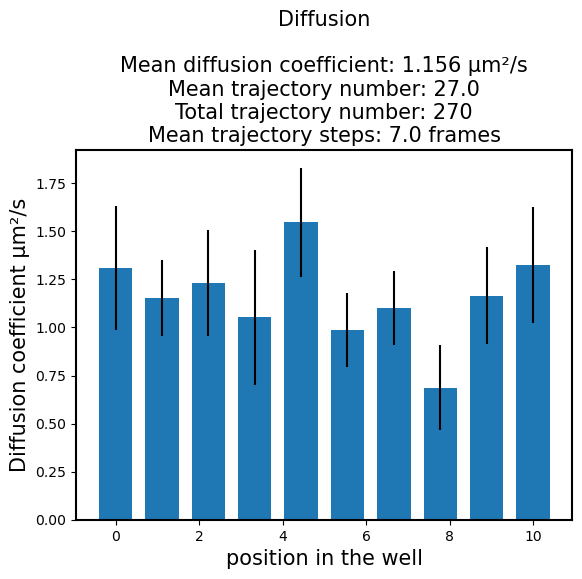

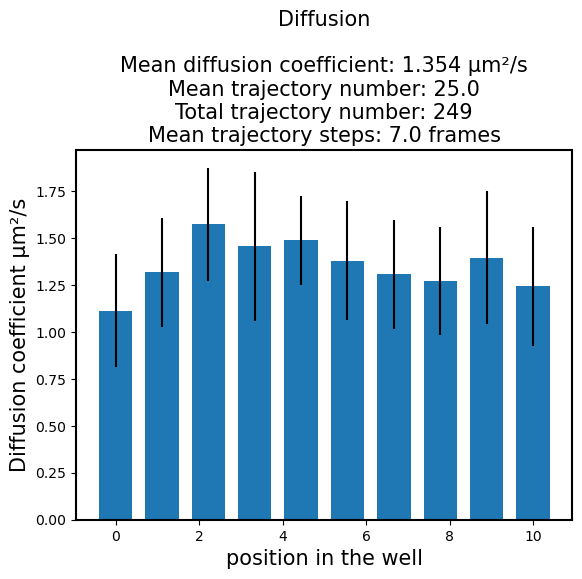

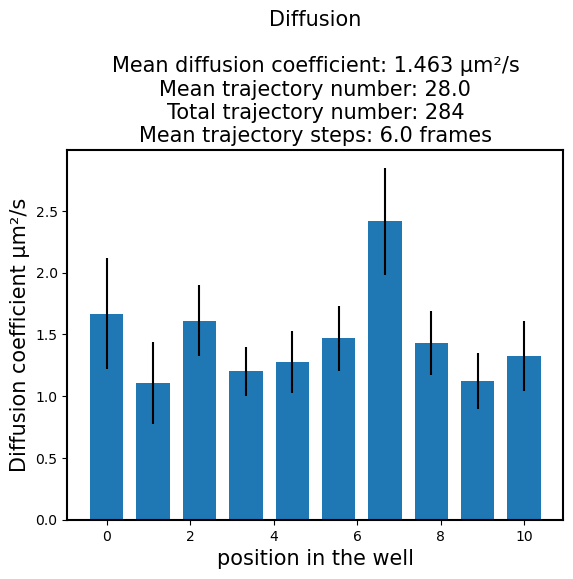

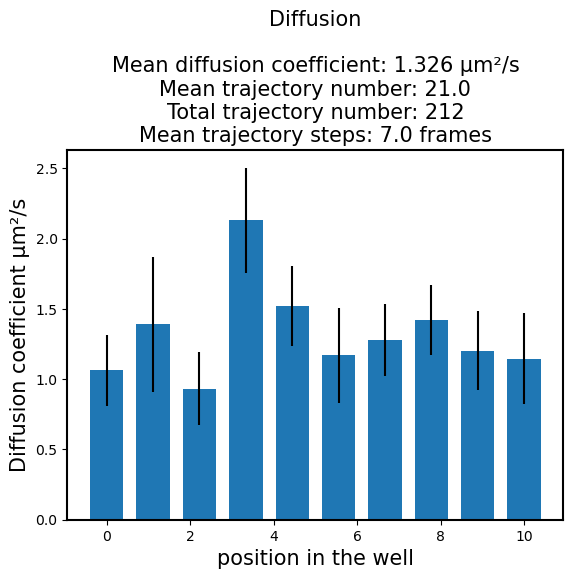

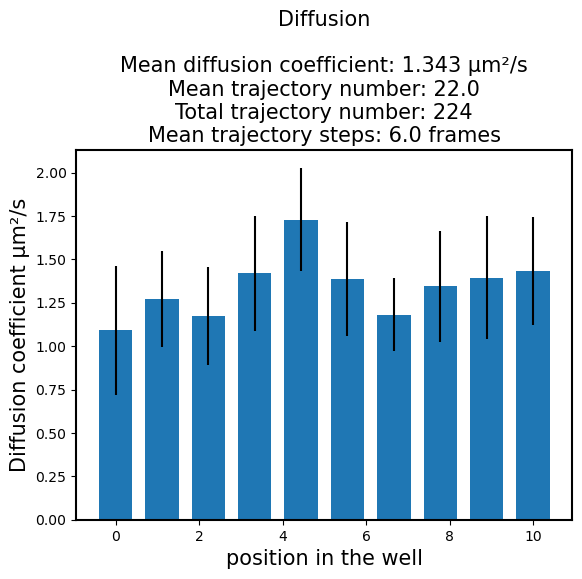

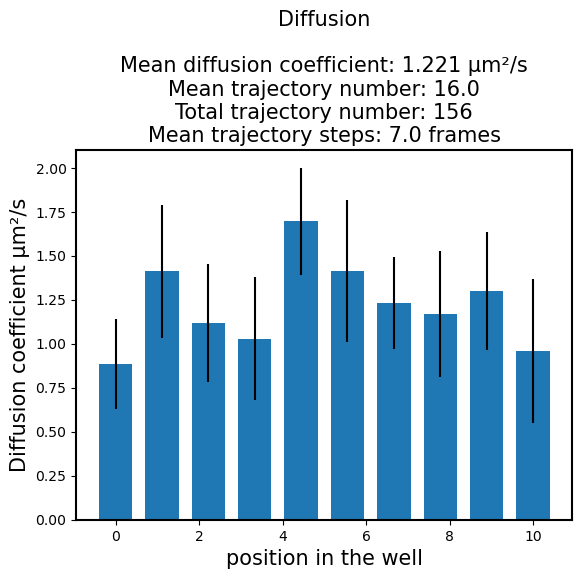

In [419]:
diffusion=[]
for i in range(0, len(filenames)):
    
    D,D_err,eps,eps_err=[],[],[],[]
    
    for g in trc[i]:

        msd_ens = motion.Msd(g, fps, pixel_size=pixel_size, ensemble=True).fit("brownian", exposure_time=exp_time)
        
        D.append(msd_ens.get_results()[0]['D'])
        eps.append(msd_ens.get_results()[0]['eps'])
        D_err.append(msd_ens.get_results()[1]['D'])
        eps_err.append(msd_ens.get_results()[1]['eps'])
        
#pd dataframe to save the data
    a,d=[],[]
    a=get_traj_parameters(trc[i])   
    d = {'D': D, 'D_err': D_err, 'eps':eps,'eps_err':eps_err, 'particles':a[0],'length [µm]':a[1],'frames':a[2]}
    diffusion=(pd.DataFrame(data=d))
    #neuuu
    # Direkt nach Erstellen des DataFrames diffusion:
    if i == 0:
        diffusion_list = []
    diffusion_list.append(diffusion)
    #neuuu
    #plot    
    fig, ax = plt.subplots()
    
    x_bar=np.linspace(0,len(trc[i]),len(trc[i]))
    plt.bar(x_bar,diffusion['D'])
    plt.errorbar(x_bar,diffusion['D'], yerr=diffusion['D_err'], marker='',ls='',ecolor='black', color='grey')
    

    ax.set(xlabel='position in the well', ylabel='Diffusion coefficient µm\u00b2/s')
    
    plt.title('Diffusion\n\n'+'Mean diffusion coefficient: '+str(np.round(np.mean(diffusion['D']),3))+' µm\u00b2/s\n'
          +'Mean trajectory number: '+str(np.round(np.mean(diffusion['particles'])))+'\n'
          +'Total trajectory number: '+str(np.round(np.sum(diffusion['particles'])))+'\n'
          +'Mean trajectory steps: '+str(np.round(np.mean(diffusion['frames'])))+ ' frames')
              
    fig.savefig(f'{data_dir}/'+filenames[i]+"_MSDperPosition.png",bbox_inches='tight')
 

## MSD analysis: individual diffusion coefficients

### Population of diffusion coefficients

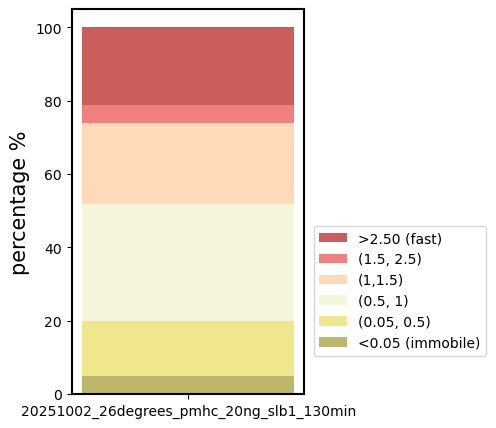

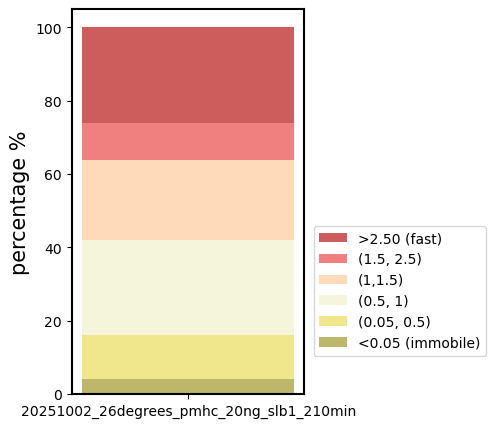

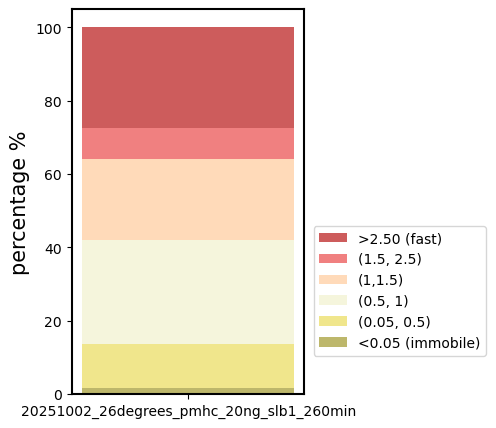

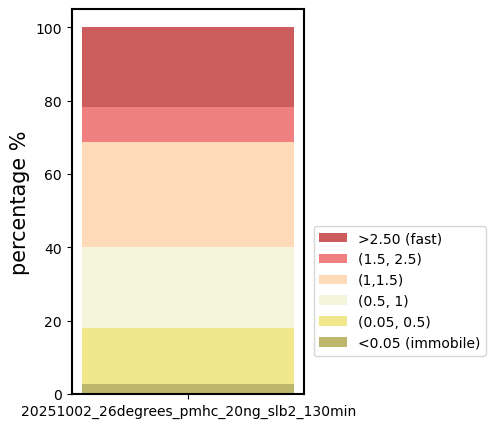

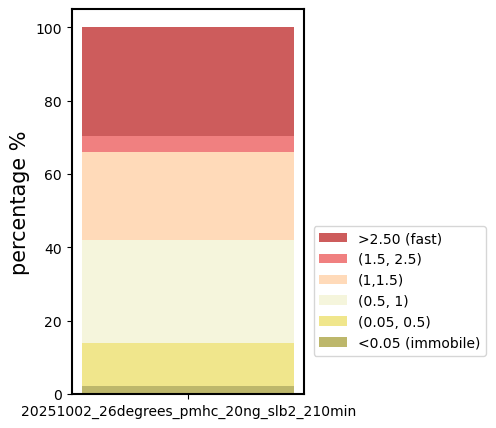

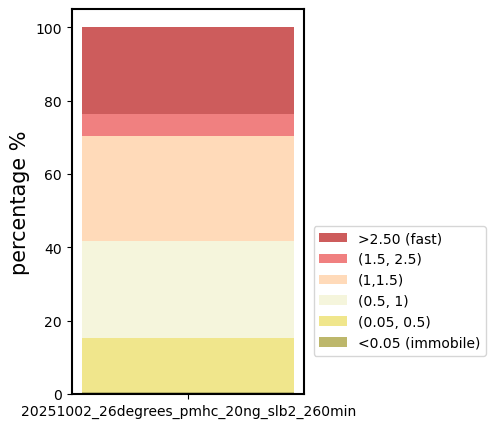

In [420]:
for i in range(0, len(filenames)):


    t, err = fit_ind[i].get_results()

    immob_perc = len(np.log(t['D'])[np.log(t['D']) < immob_thresh])/len(np.log(t['D']))
    super_slow_perc = len(np.log(t['D'])[(np.log(t['D']) < super_slow_tresh)&(np.log(t['D'])>= immob_thresh)])/len(np.log(t['D']))
    slow_perc = len(np.log(t['D'])[(np.log(t['D']) < slow_tresh)&(np.log(t['D'])>= super_slow_tresh)])/len(np.log(t['D']))
    normal_perc = len(np.log(t['D'])[(np.log(t['D']) < normal_tresh)&(np.log(t['D'])>= slow_tresh)])/len(np.log(t['D'])) 
    middle_perc = len(np.log(t['D'])[(np.log(t['D']) < fast_tresh)&(np.log(t['D'])>= normal_tresh)])/len(np.log(t['D']))
    fast_perc = len(np.log(t['D'])[(np.log(t['D'])>= fast_tresh)])/len(np.log(t['D']))
    rest=100*(immob_perc+slow_perc+super_slow_perc+normal_perc+fast_perc)

    if i == 0:
        immob_perc_list = []
        super_slow_perc_list = []
        slow_perc_list = []
        normal_perc_list = []
        middle_perc_list = []
        fast_perc_list = []
        rest_list = []
        
    immob_perc_list.append(immob_perc)
    super_slow_perc_list.append(super_slow_perc)
    slow_perc_list.append(slow_perc)
    normal_perc_list.append(normal_perc)
    middle_perc_list.append(middle_perc)
    fast_perc_list.append(fast_perc)
    rest_list.append(rest)
    
    
#plot population
    fig, ax = plt.subplots(figsize=(3,5))

#name of the sample
    x=filenames[i]


    #rest=100*(immob_perc+slow_perc+super_slow_perc+normal_perc+fast_perc)
    plt.bar(x,100-rest ,bottom=rest,label=label_fast,color='indianred')
    plt.bar(x, 100*fast_perc ,bottom=100*(immob_perc+slow_perc+normal_perc+super_slow_perc),label=label_middle,color='lightcoral')
    plt.bar(x,100*normal_perc ,bottom=100*(immob_perc+slow_perc+super_slow_perc),label=label_normal, color='peachpuff')
    plt.bar(x,100*slow_perc ,bottom=100*(immob_perc+super_slow_perc),label=label_slow, color='beige')
    plt.bar(x, 100*super_slow_perc ,bottom=100*immob_perc,label=label_superslow ,color='khaki')
    plt.bar(x, immob_perc*100, label=label_immobile, color='darkkhaki')

   
    plt.ylabel('percentage %')
    plt.legend(loc=(1.04, 0.1))

    fig.savefig(f'{data_dir}/'+filenames[i]+"_population.png",bbox_inches = "tight")
 


### Brightness and frames 

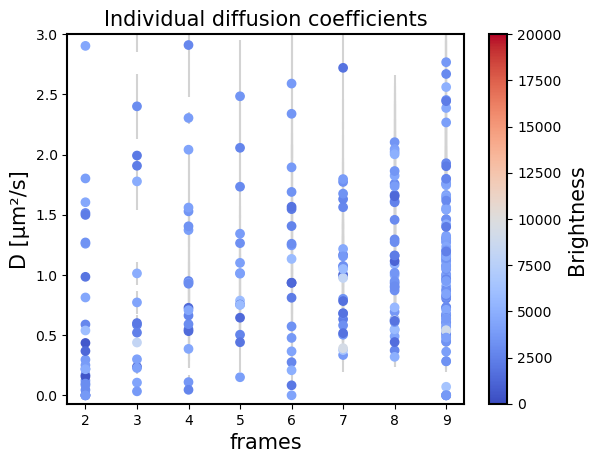

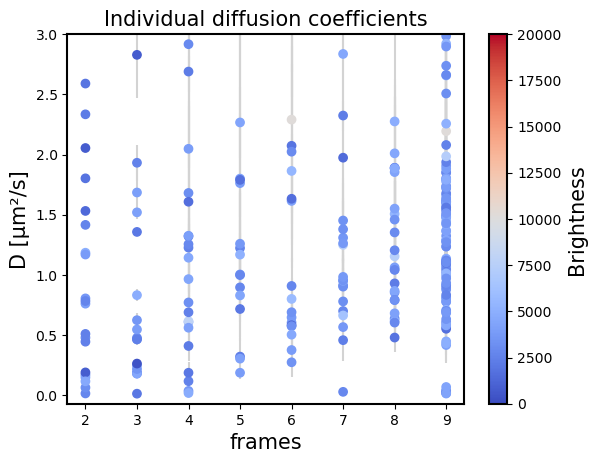

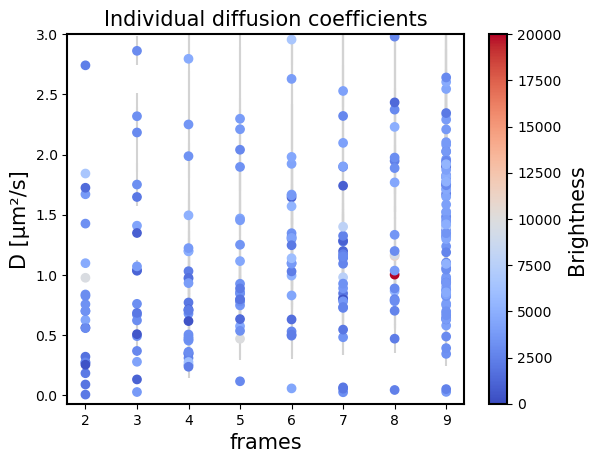

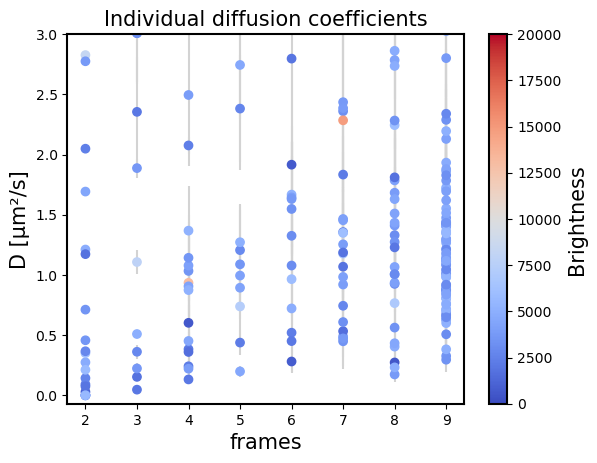

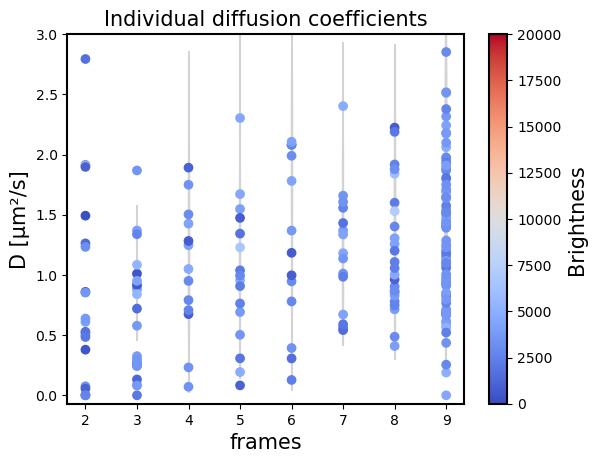

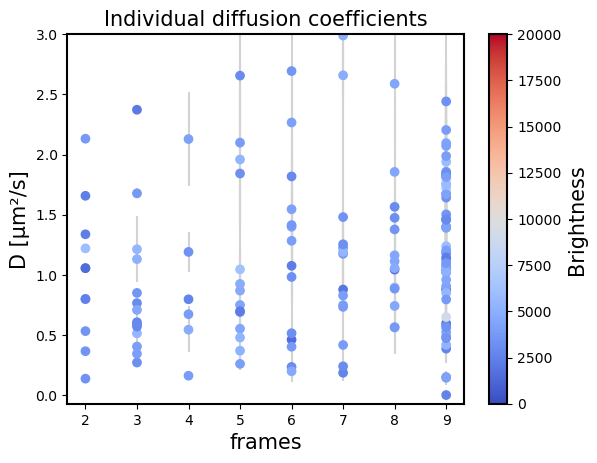

In [421]:
for i in range(0, len(filenames)):
    D_ind=fit_ind[i].get_results()[0]['D']
    D_err_ind=fit_ind[i].get_results()[1]['D']

    steps, steps_norm, mass, diffusion_ind=[],[],[], []

    for l in range(0,len(trc[i])):
    
        steps.append(get_traj_steps(trc[i][l]))
        ma=trc[i][l].drop_duplicates('particle')
        mass.append(ma['mass'].to_numpy())

# create a dataframe
        d_ind = {'D': D_ind[l], 'D_err': D_err_ind[l], 'steps':steps[l], 'mass':mass[l]}
        diffusion_ind.append(pd.DataFrame(data=d_ind))
        
#plot 
    fig, ax = plt.subplots()
    for k in range(0,len(diffusion_ind)):
        plt.scatter( diffusion_ind[k]['steps'],diffusion_ind[k]['D'], c=diffusion_ind[k]['mass'], cmap='coolwarm',vmin=0, vmax=20000, zorder=1)
        plt.errorbar(diffusion_ind[k]['steps'],diffusion_ind[k]['D'],yerr = diffusion_ind[k]['D_err'], marker='',ls='',ecolor='lightgray',zorder=0)

        plt.ylim((-0.07,3))
        
    plt.colorbar(label="Brightness", orientation="vertical")
    plt.xlabel('frames')
    plt.ylabel('D [µm\u00b2/s]')
    plt.title('Individual diffusion coefficients')
    fig.savefig(f'{data_dir}/'+filenames[i]+"_Brightness.png",bbox_inches='tight')
 

  0%|          | 0/6 [00:00<?, ?it/s]

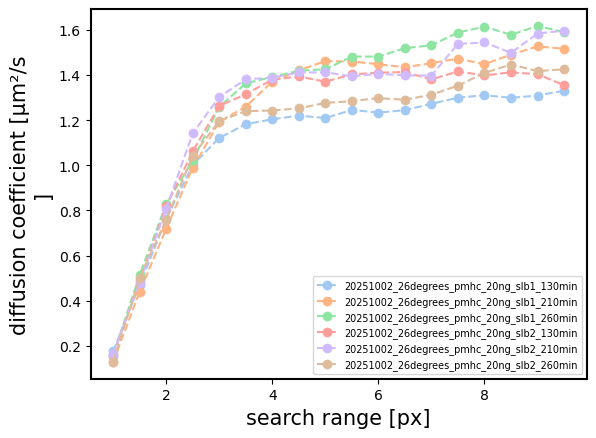

In [422]:
first_frame_for_check=90

def search_range_check(data_brightness, data_files_brightness_filename, data_loc_brightness, memory, fps, pixel_size,exp_time):
    range_list=np.arange(1,10,0.5)
    cols=sns.color_palette("pastel", n_colors=len(data_files_brightness_filename))


    fig, ax = plt.subplots()

    for j in tqdm(range(0,len(data_files_brightness_filename))):
        dcoef=[]
    
        for i in range_list:
            trc = [trackpy.link(d[d['frame'] >= first_frame_for_check], search_range=i, memory=memory) for d in data_loc_brightness[j]]
            m = motion.Msd(trc, frame_rate=fps, pixel_size=pixel_size)
            f = m.fit("brownian", n_lag=2, exposure_time=exp_time)
            fit, fit_err = f.get_results()
            dcoef.append((fit.iloc[0]))


        plt.plot(range_list,dcoef, '--o', color=cols[j], label=data_files_brightness_filename[j])

    plt.xlabel('search range [px]')
    plt.ylabel('diffusion coefficient [µm\u00b2/s\n]')
    plt.legend(fontsize=7)
    
    fig.savefig(f'{data_brightness}/'+"_search_range_test.png",bbox_inches='tight')
    plt.close(fig)

    return fig

search_range_check(data_brightness=data_dir, data_files_brightness_filename=filenames, data_loc_brightness=data_loc, memory=memory, fps=fps, pixel_size=pixel_size, exp_time=exp_time)

In [423]:
data_dir

'/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/origami_37vs26degrees_1002_1010/20251002_26degrees/pmhc/20ng'

/var/folders/_z/fj6p1tzs10j6cmtrm_v7mh8h0000gn/T/ipykernel_23559/443338282.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(data_groups))


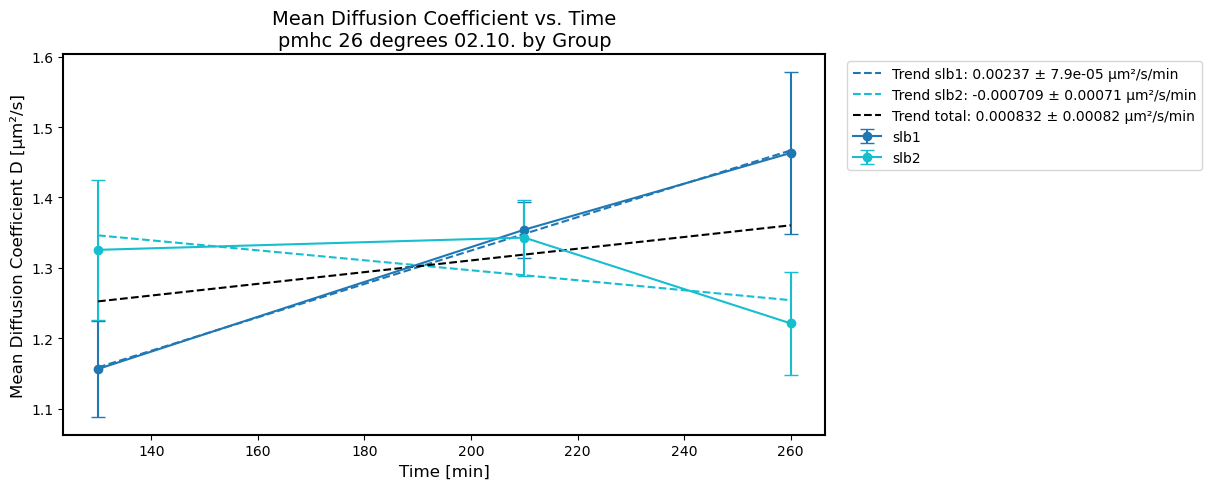

In [424]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import os

# Zeitpunkte und Mittelwerte sammeln
data_groups = ['slb1', 'slb2']
custom_title = "pmhc 26 degrees 02.10."
times = []
mean_D = []
sem_D = []
groupnames = []

# Gruppenzuordnung 
for filename in filenames:
    group = next((g for g in data_groups if g in filename), None)
    groupnames.append(group)

# Werte sammeln
for i, filename in enumerate(filenames):
    # Zeit aus Dateiname holen
    m = re.search(r'_(\d+)min', filename)
    if m:
        times.append(int(m.group(1)))
    else:
        times.append(np.nan)

    # Mittelwert und SEM berechnen
    Ds = diffusion_list[i]['D'].to_numpy()
    mean_D.append(np.nanmean(Ds))
    sem_D.append(np.nanstd(Ds)/np.sqrt(len(Ds)) if len(Ds) > 0 else np.nan)

times = np.array(times)
mean_D = np.array(mean_D)
sem_D = np.array(sem_D)
groupnames = np.array(groupnames)

# Farben automatisch
cmap = cm.get_cmap('tab10', len(data_groups))
colors = {g: cmap(i) for i, g in enumerate(data_groups)}

plt.figure(figsize=(15, 5))  # Mehr Platz

for i, group in enumerate(data_groups):
    mask = (groupnames == group)
    if np.sum(mask) == 0:
        continue
    group_times = times[mask]
    group_mean_D = mean_D[mask]
    group_sem_D = sem_D[mask]
    sort_idx = np.argsort(group_times)
    group_times = group_times[sort_idx]
    group_mean_D = group_mean_D[sort_idx]
    group_sem_D = group_sem_D[sort_idx]
    
    plt.errorbar(
        group_times, group_mean_D, yerr=group_sem_D, fmt='o-', 
        capsize=5, label=group, color=colors[group]
    )
    if np.sum(~np.isnan(group_mean_D)) >= 2:
        coef, cov = np.polyfit(group_times, group_mean_D, 1, cov=True)
        p = np.poly1d(coef)
        x_fit = np.linspace(np.nanmin(group_times), np.nanmax(group_times), 100)
        y_fit = p(x_fit)
        slope = coef[0]
        slope_err = np.sqrt(cov[0,0])
        trend_label = f"Trend {group}: {slope:.3g} ± {slope_err:.2g} µm²/s/min"
        plt.plot(x_fit, y_fit, '--', color=colors[group], label=trend_label)
        
# Gesamtrend berechnen
coef, cov = np.polyfit(times, mean_D, 1, cov=True)
p = np.poly1d(coef)
x_fit = np.linspace(np.nanmin(times), np.nanmax(times), 100)
y_fit = p(x_fit)
slope = coef[0]
slope_err = np.sqrt(cov[0,0])
trend_label = f"Trend total: {slope:.3g} ± {slope_err:.2g} µm²/s/min"
plt.plot(x_fit, y_fit, '--', color='black', label=trend_label)

plt.xlabel("Time [min]", fontsize=12)
plt.ylabel("Mean Diffusion Coefficient D [µm²/s]", fontsize=12)
plt.title(f"Mean Diffusion Coefficient vs. Time\n{custom_title} by Group", fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, fontsize=10)
plt.tight_layout(rect=[0, 0, 0.82, 1])  # Platz für Legende

save_dir = f'{data_dir}/plots'
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, "Mean_D_vs_Time_by_group.png"), bbox_inches='tight')
plt.show()

In [425]:
print(group_times)
save_dir

[130 210 260]


'/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/origami_37vs26degrees_1002_1010/20251002_26degrees/pmhc/20ng/plots'

In [426]:
print(times)

[130 210 260 130 210 260]


/var/folders/_z/fj6p1tzs10j6cmtrm_v7mh8h0000gn/T/ipykernel_23559/1105644211.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  subpop_cmap = cm.get_cmap('Set1', 6)


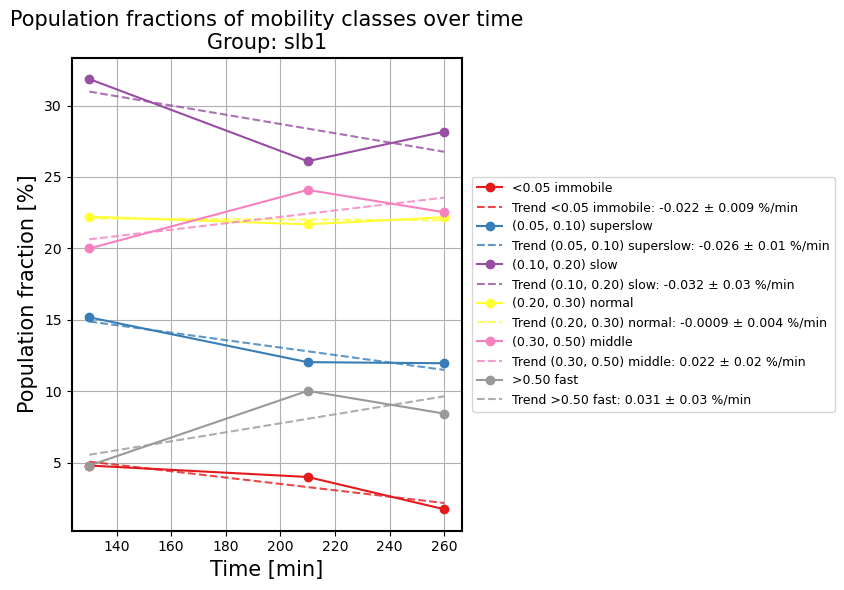

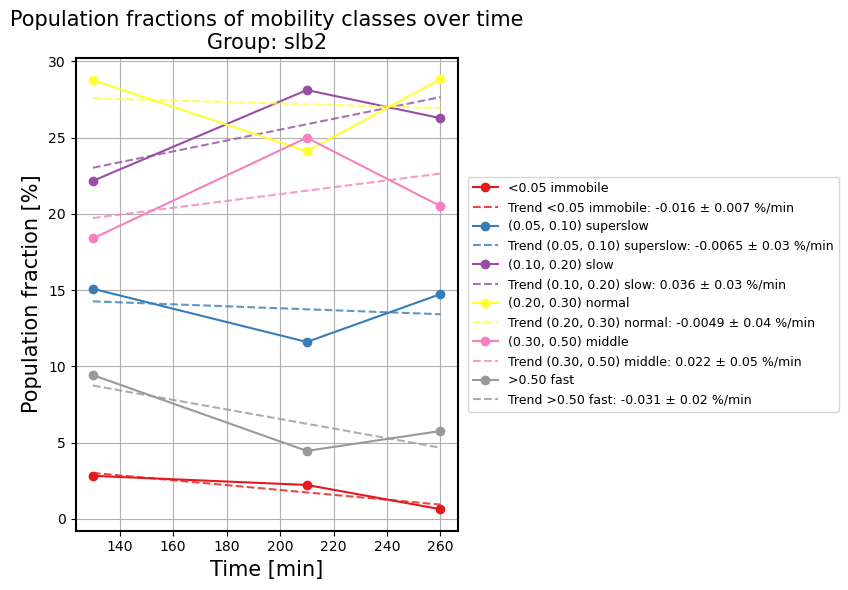

In [427]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

subpop_cmap = cm.get_cmap('Set1', 6)

# Intervall + Name
intervals = [
    '<0.05',
    '(0.05, 0.10)',
    '(0.10, 0.20)',
    '(0.20, 0.30)',
    '(0.30, 0.50)',
    '>0.50'
]
typenames = [
    'immobile',
    'superslow',
    'slow',
    'normal',
    'middle',
    'fast'
]
pop_lists = [
    immob_perc_list,
    super_slow_perc_list,
    slow_perc_list,
    normal_perc_list,
    middle_perc_list,
    fast_perc_list
]

for g_idx, group in enumerate(data_groups):
    plt.figure(figsize=(10,6))
    mask = (np.array(groupnames) == group)
    if np.sum(mask) == 0:
        continue

    group_times = times[mask]
    sort_idx = np.argsort(group_times)
    group_times = group_times[sort_idx]

    for l_idx, (interval, typename, pop_list) in enumerate(zip(intervals, typenames, pop_lists)):
        perc = np.array(pop_list)[mask] * 100
        perc = perc[sort_idx]
        color = subpop_cmap(l_idx)
        
        # Label wie gewünscht
        line_label = f"{interval} {typename}"
        plt.plot(group_times, perc, marker='o', label=line_label, color=color)
        
        # Trendlinie und Label
        if np.sum(~np.isnan(perc)) >= 2:
            coef, cov = np.polyfit(group_times, perc, 1, cov=True)
            p = np.poly1d(coef)
            x_fit = np.linspace(np.nanmin(group_times), np.nanmax(group_times), 100)
            y_fit = p(x_fit)
            slope = coef[0]
            slope_err = np.sqrt(cov[0,0])
            trend_label = f"Trend {interval} {typename}: {slope:.2g} ± {slope_err:.1g} %/min"
            plt.plot(x_fit, y_fit, '--', color=color, alpha=0.8, label=trend_label)

    plt.xlabel("Time [min]")
    plt.ylabel("Population fraction [%]")
    plt.title(f"Population fractions of mobility classes over time\nGroup: {group}")
    plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=True, fontsize=9)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.grid(True)

    save_dir = f'{data_dir}/plots'
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"Population_Fractions_vs_Time_{group}_trends_named.png"), bbox_inches='tight')
    plt.show()


/var/folders/_z/fj6p1tzs10j6cmtrm_v7mh8h0000gn/T/ipykernel_23559/2850924013.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  subpop_cmap = cm.get_cmap('Set1', 6)


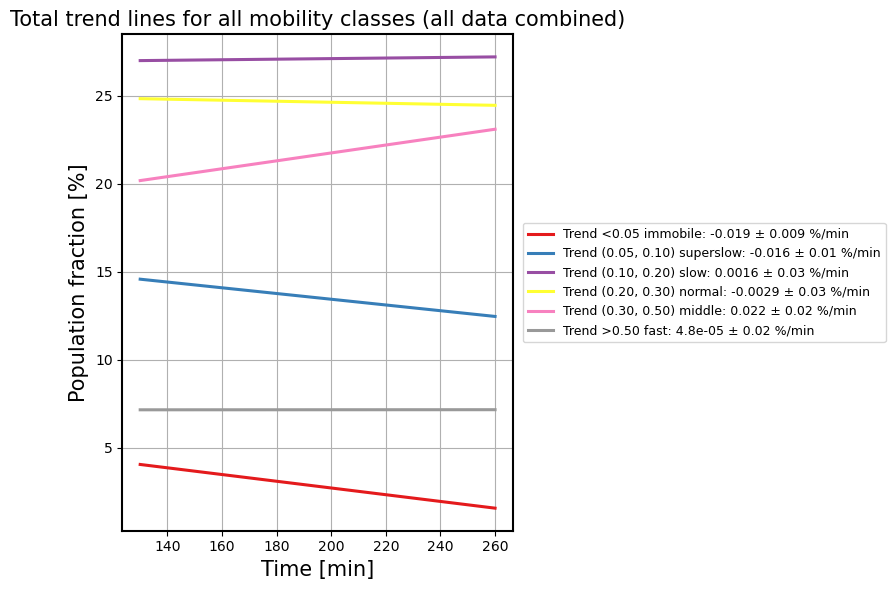

In [428]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

subpop_cmap = cm.get_cmap('Set1', 6)

intervals = [
    '<0.05',
    '(0.05, 0.10)',
    '(0.10, 0.20)',
    '(0.20, 0.30)',
    '(0.30, 0.50)',
    '>0.50'
]
typenames = [
    'immobile',
    'superslow',
    'slow',
    'normal',
    'middle',
    'fast'
]
pop_lists = [
    immob_perc_list,
    super_slow_perc_list,
    slow_perc_list,
    normal_perc_list,
    middle_perc_list,
    fast_perc_list
]

plt.figure(figsize=(10,6))

all_times = np.array(times)

for l_idx, (interval, typename, pop_list) in enumerate(zip(intervals, typenames, pop_lists)):
    color = subpop_cmap(l_idx)
    perc = np.array(pop_list) * 100
    valid_mask = ~np.isnan(perc) & ~np.isnan(all_times)
    if np.sum(valid_mask) >= 2:
        coef, cov = np.polyfit(all_times[valid_mask], perc[valid_mask], 1, cov=True)
        p = np.poly1d(coef)
        x_fit = np.linspace(np.nanmin(all_times[valid_mask]), np.nanmax(all_times[valid_mask]), 100)
        y_fit = p(x_fit)
        slope = coef[0]
        slope_err = np.sqrt(cov[0,0])
        label = f"Trend {interval} {typename}: {slope:.2g} ± {slope_err:.1g} %/min"
        plt.plot(x_fit, y_fit, '-', color=color, linewidth=2.2, label=label)

plt.xlabel("Time [min]")
plt.ylabel("Population fraction [%]")
plt.title("Total trend lines for all mobility classes (all data combined)")
plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=True, fontsize=9)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.grid(True)

save_dir = f'{data_dir}/plots'
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, "Population_TotalTrends_perClass.png"), bbox_inches='tight')
plt.show()
